In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation,rc
from IPython.display import HTML
from integrators import *
from n_body_rhs import *
from n_body_ic import *
import time
import scipy as sp
from scipy.integrate import solve_ivp

def plot_3body(y):
    # show trajectories of all bodies on the same plot
    plt.plot(y[:,0],y[:,1],label='body1')
    plt.plot(y[:,2],y[:,3],label='body2')
    plt.plot(y[:,4],y[:,5],label='body3')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()

# Project 5.19. The classical helium atom

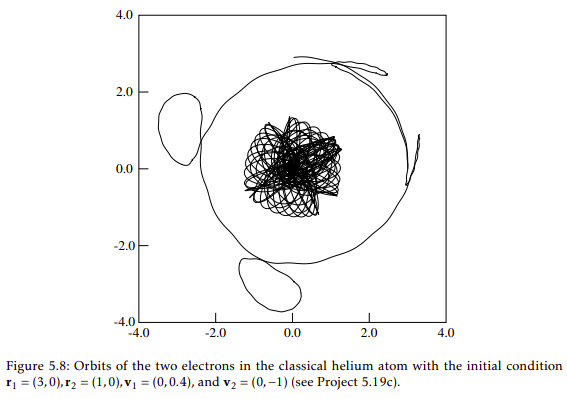

The classical helium atom is a relatively simple example of a three-body problem and is similar
to the gravitational three-body problem of a heavy sun and two light planets. The important
difference is that the two electrons repel one another, unlike the planetary case where the intraplanetary interaction is attractive. If we ignore the small motion of the heavy nucleus, the
equations of motion for the two electrons can be written as

$$ a_1 = -2\frac{r_1}{r_1^3} + \frac{r_1-r_2}{r_{12}^3} $$
$$ a_2 = -2\frac{r_2}{r_2^3} + \frac{r_2-r_1}{r_{12}^3} $$

where $r_1$ and $r_2$ are measured from the fixed nucleus at the origin, and $r_{12}$ is the distance between the two electrons. We have chosen units such that the mass and charge of the electron
are both unity. The charge of the helium nucleus is two in these units. Because the electrons
are sometimes very close to the nucleus, their acceleration can become very large, and a very
small time step ∆t is required. It is not efficient to use the same small time step throughout
the simulation, and instead a variable time step or an adaptive step size algorithm is suggested.
An adaptive step size algorithm can be used with any standard numerical algorithm for solving
differential equations. The RK45 algorithm described in Appendix 3A is adaptive and is a good
all-around choice for these types of problems.

(a) For simplicity, we restrict our atom to two dimensions. Modify Planet2 (n_body_rhs) to simulate the classical helium atom.  Choose units such taht the electron mass is one and the other constants are absorbed into the unit of charge so that the force between two electrions is

$$ F = \frac{1}{r^2} $$

where r is the distance between the electrons.

Choose the initial value of the time step to be $\delta t = 0.001$.  Some of the possible orbuts are similar to those we have seen in our mini solar system.  For example, try the initial condition:

 $r_1 = (2, 0)$, $r_2 = (-1, 0)$, $v_1 = (0, 0.95)$, $v_2 = (0, -1)$.

In [2]:
# new force function for helium
def helium_force(m1, m2, g, r_vec):
    '''
    Calculate force between particles in helium atom
    m1, m2: charges (-1 for electrons, 2 for nucleus)
    r_vec: vector from m2 to m1
    Returns force vector on m1 due to m2
    '''
    r_hat = np.linalg.norm(r_vec)
    if r_hat == 0:  # Prevent division by zero
        return np.zeros_like(r_vec)
    # Coulomb force: F = q1*q2*r_vec/r^3
    # Units chosen where |F| = 1/r^2 between electrons
    return m1 * m2 * r_vec / (r_hat**3)

In [3]:
# new rhs function for helium
def n_body_helium(t, y, p):
    G = p['G']
    charges = p['m']  # m is charges in this case
    n = len(charges)
    d = p['dimension']
    
    positions = y[:n*d].reshape((n, d))
    velocities = y[n*d:].reshape((n, d))
    
    F = np.zeros((n, n, d))
    
    # Calculate forces
    for i in range(n):
        for j in range(i+1, n):
            r_vec = positions[i] - positions[j]
            force = helium_force(charges[i], charges[j], G, r_vec)
            F[i,j] = -force
            F[j,i] = force

    # Compute accelerations (F/m, mass = 1 for electrons)
    acc = np.zeros_like(positions)
    for i in range(n):
        total_force = np.sum(F[i], axis=0)
        acc[i] = total_force / charges[i]  # mass = 1
    
    dydt = np.concatenate((velocities.flatten(), acc.flatten()))
    if p.get("fix_first", True):
        dydt[:d] = 0.0
        
    return dydt

In [ ]:
y0 = helium_1
p_he = {'m':array([2,-1,-1]),'G':1,'dimension':2,'force':helium_force,'fix_first':True}
dt = .001
t_span = [0,10]
d=2

atol = 1e-6
rtol = 1e-6

def part_a():
    y0 = np.array([0, 0, 2, 0, -1, 0, 0, 0, 0, 0.95, 0, -1])  # body 1 is our fixed nucleus
    t_span = [0, 100]
    dt = 0.001
    
    t_s,y = solve_ode_RK45(n_body_helium,t_span, y0, RK45, args=(p_he,),atol=atol,rtol=rtol,first_step=dt)
    # solution = solve_ivp(n_body_helium, t_span, y0, args=(p_he,), method='RK45', rtol=rtol, atol=atol, t_eval=np.arange(t_span[0], t_span[1], dt))
    # print(solution)
    # t_s_n = solution.t
    # y = solution.y.T
    # print(y)
    # print(y_n)
    plt.plot(y[:, 2], y[:, 3], label='electron 1')
    plt.plot(y[:, 4], y[:, 5], label='electron 2')
    plt.plot([0], [0], 'ro', label='nucleus')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.title('Helium Atom Orbits - Part (a)')
    plt.show()

start_t = time.time()
part_a()
end_t = time.time()
print("Time Elapsed = %4.3f seconds."%(end_t-start_t))
# plot_3body(y)
# anim = show_anim(t_s,y)
# HTML(anim.to_html5_video())
# plt.style.use("seaborn-v0_8")
# plt.axis("on")
# E = total_energy(y,p)
# #plt.plot(E,'r')
# small = 1e-7
# plt.ylim(E.min()*(1-small),E.max()*(1+small))

(b) Most initial conditions result in unstable orbits in which one electron eventually leaves
the atom (autoionization). The initial condition $r_1$ = (1.4,0), $r_2$ = (−1,0), $v_1$ = (0,0.86), and
$v_2$ = (0,−1) gives “braiding” orbits. Make small changes in this initial condition to observe
autoionization.

In [ ]:
def part_b():
    y0_base = np.array([0, 0, 1.4, 0, -1, 0, 0, 0, 0, 0.86, 0, -1])
    perturbations = [0, 0.01, -0.01]
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Helium Atom - Braiding and Autoionization for Different Perturbations', fontsize=16)
    
    for i, dp in enumerate(perturbations):
        y0 = y0_base.copy()
        y0[9] += dp  # perturb v1y (velocity y-component of electron 1)
        t_span = [0, 100]
        
        # Run simulation
        print(f"Running simulation for perturbation dp={dp}...")
        t, y = solve_ode_RK45(n_body_helium, t_span, y0, RK45, args=(p_he,), first_step=0.001)
        
        ax = axes[i]
        ax.plot(y[:, 2], y[:, 3], 'b-', label='electron 1')
        ax.plot(y[:, 4], y[:, 5], 'g-', label='electron 2')
        ax.plot(0, 0, 'ro', label='nucleus')
        
        # circle for ionization threshold (arbitrary radius of 6)
        ionization_circle = plt.Circle((0, 0), 6, color='r', fill=False, linestyle='--', alpha=0.5)
        ax.add_patch(ionization_circle)
        
        # Set equal aspect ratio
        ax.set_aspect('equal')
        
        # Add labels and title
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title(f'Perturbation: {dp}')
        ax.legend()
        
        # Add grid
        ax.grid(True, linestyle='--', alpha=0.7)
        
        # Set equal axis limits across all plots for better comparison
        ax.set_xlim(-7, 7)
        ax.set_ylim(-7, 7)
        
        # Check for autoionization
        max_distance = max(
            np.max(np.sqrt(y[:, 2]**2 + y[:, 3]**2)),  # max distance of electron 1
            np.max(np.sqrt(y[:, 4]**2 + y[:, 5]**2))   # max distance of electron 2
        )
        
        if max_distance > 6:
            ax.text(0.5, 0.05, 'Autoionization detected', 
                   transform=ax.transAxes, color='red', 
                   fontsize=12, ha='center')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)  # Adjust to make room for the suptitle
    
    return fig

start_t = time.time()
fig = part_b()
plt.show()
end_t = time.time()
print("Time Elapsed = %4.3f seconds."%(end_t-start_t))